## TP 2: Filtrage du spam 
___

Nous proposons dans ce TP deux techniques pour la détection de spam. Il s'agit d'identifier si un mail fait partie des messages indésirables (spam) ou dans des messages légitimes (ham).

La base de données utilisée est $Enron^{(1)(2)}$. Nous allons spécifier par la suite les dossiers utilisés pour l'entrainement et le test.

Les 2 techniques que nous utilisons sont : la calssification naive bayésienne et la régression logistique.

_**Remarques importantes:**_

- Nous utilisons la version 1.1.0 de Julia.

- Vous pouvez télécharger les deux dossier "enron1" et "enron2" qui seront utilisés dans ce TP et les mettre dans un dossier "data". Vous trouverez le fichier "trainData.jld" sur moodle, (à mettre dans le dossier "data" également) ce qui vous permettra d'éviter de relancer l'entrainement.

### Sommaire:
___


[I. Etat de l'art du filtrage du spam](#unit1)  
[II. Classification naive bayésienne](#unit2)  
[III. Régression logistique](#unit3)  
[III.1. Préparation des données](#unit3.1)  
[III.2. Méthode MCMC - Metropolis Hastings](#unit3.2)  
[III.3. Descente de gradient](#unit3.3)  
[IV. Références](#unit4)  

### I. Etat de l'art du filtrage du spam <a id = "unit1" > </a >
___

Pendent les dernière années, les gens ont commencé à utiliser la méthode de descente de gradient pour éviter le problème des matrices non inversibles (overfitting) en utilisant la régression logistique. Le passage à la régression logistique avec la méthode de descente de gradient a amélioré les performances significativement tout en permettant de prendre en compte les corrélations entre les mots. Cependant la classification naive bayésienne reste très simple tout en donnant des résultats impressionants. Nous allons alors explorer la classification naive bayésienne et la régression logistique (avec l'algorithme de Metropolis-Hastings et la descente de gradient). **Ne paniquez pas si vous ne comprenez pas les termes utilisés, tout sera expliqué par la suite**.


### II. Classification naive bayésienne <a id = "unit2" > </a >
___

La classification naive bayésienne$^{(3)}$ consiste à utiliser le théoreme de Bayes pour calculer la probabilité à posteriori en estimant les probabilités conditionnelles d'une façon naive à partir des données d'entrainement.

Dans notre contexte, notons la variable d'intérêt $S$ qui est égale à $1$ si le mail est un Spam et $0$ sinon. Soit $W$ le vecteur des mots contenus dans un mail donné par $W = (w_1, ..., w_n)$. Alors, selon **le théorème de Bayes**, la probabilité que le mail soit un spam sachant son contenu (les mots qu'il contient) est:

$$ P(S|W) = \frac{P(W|S) P(S)}{P(W)}$$


- La probabilité $P(S)$ représente notre probabilité a priori que le mail soit un spam. Dans ce TP, nous prenons **$P(S=1) = P(S=0) = \frac{1}{2}$**. Cependant, nous pouvons aussi laisser cette probabilité comme un **hyperparametre** de notre algorithme que nous pouvons déterminer en utilisant **La validation croisée**. Dans ce cas, la probabilité qui sera retenue est celle qui minimise l'erreur de classification sur l'ensemble de validation.  


- La probabilité $P(W) = P(W|S) P(S) + P(W|\overline{S}) P(\overline{S})$ n'est pas importante, car pour classifier un mail en tant que un spam ou non, nous allons comparer $P(S = 1|W) = \frac{P(W|S = 1) P(S = 1)}{P(W)}$ et $P(S = 0|W) = \frac{P(W|S = 0) P(S = 0)}{P(W)}$. Les 2 partagent le même dénominateur, donc il suffit de comparer les nominateurs. C'est ce qu'on va faire dans ce TD.

- Il reste l'estimation de la probabilité $P(W|S) = P(w_1, ..., w_n|S)$. Il est très difficile d'estimer cette probabilité à partir de l'ensemble d'entrainement directement. Pour cela, on fait **l'hypothèse (importante) de l'indépendance** qui caractérise la classification naive bayésienne: les mots sont considérés conditionnellement indépendants, donc on peut écrire:

$$P(W|S) = P(w_1, ..., w_n|S) = P(w_1|S) \times .. \times P(w_n|S) = \prod_{i=1}^{n} P(w_i|S) $$

Nous pouvons alors estimer directement les probabilités $P(w_i|S)$. Pour un mot donné $w_i$, la probabilité $P(w_i|S)$ représente la fréquence de son apparition dans l'ensemble d'entrainement (la présence d'un mot dans un mail n'est comptée qu'une seule fois).

Passons maintenant à l'implémentation de cette approche. Nous allons devoir parser tous les mails de l'ensemble d'entrainement. Nous utilisons le dossier *enron1* en tant qu'ensemble d'entrainement.




In [1]:
using DataFrames
using Distributions
using JLD
using Plots
using Query
using Random

Nous créons la fonction *textProcessing* qui prend un texte et retourne l'ensemble de mots contenus dans le texte (de longueur supérieure strictement à 1.

In [2]:
"""
textProcessing: transformer un texte en une liste de mots
            qui figurent dans le texte, en enlevant toute substance
            de longueur inférieure à 2 et en mettant toutes les
            lettres en minuscule
input : - text [str]: chaîne de caractères 
output: - words [Array]: tableau qui contient les mots (chaînes de caractères)
            qui figurent dans le texte
"""

function textProcessing(text)
    # définir les séparateurs dans un texte
    separators = [' ','-', '.', '_', '!', '@', ':', ',', '/', ';']
    # mettre toutes les lettres en minuscule
    # utiliser les séparateurs pour séparer les mots
    words = split(lowercase(text), separators)
    # garder uniquement les substances à longueur supérieure strictement à 1
    words = filter(x -> length(x) > 1, words)
    # éviter la repétition des mots
    words = unique(words)
    
    return words
end

textProcessing (generic function with 1 method)

Ensuite, nous créons la fonction *parseEmail* qui prend en entrée le chemin vers un fichier-mail et effectue la lecture du mail ligne par ligne en utilisant la fonction définie précédemment *textProcessing* afin de récupérer les mots de chaque ligne.

In [3]:
"""
parseEmail: renvoyer une liste des mots qui figurent dans un mail
input : - file_path [str]: chemin vers le fichier contenant le mail
output: - list_words [Array] : tableau qui contient les mots (chaînes de caractères)
            qui figurent dans le mail
"""
function parseEmail(file_path)
    # initialiser la liste des mots
    list_words = []
    # lire le mail
    f = open(file_path)
    lines = readlines(f)
    for line in lines
        # récupérer les mots figurant dans cette ligne
        words = textProcessing(line)
        # concaténer tous les mots
        list_words = vcat(list_words,words)
    end
    # éviter les répétition des mots
    list_words = unique(list_words)
    close(f)
    return list_words   
end


parseEmail

La fonction *getTrainDF* permet de créer une dataframe qui contient tous les mots de l'ensemble d'entrainement et leurs probabilités (fréquences d'apparition). Notons bien que la lecture de certains fichiers retourne une erreur lorsqu'il contient des chaine de caractères avec un encodage non supporté par Julia pour les chaines de caractères. Pour cela, nous utilisons des outils de gestion d'exceptions (try/catch) et nous notons le nombre de fichiers non utilisés.

In [4]:
"""
getTrainDF: Créer un DFionnaire qui contient tous les mots
            contenus dans les mails de l'ensemble d'entrainement.
            Ces mots représentent les clés. Pour une clé donnée, la valeur
            représente le nombre de mails dans lesqueles la clé (le mot)
            est apparue. Cela donne la fréquence d'apparition de chaque
            mot dans les mails.
input : - dir_path [str]: chemin vers le dossier qui contient les mails
output: - trainDF [Dataframe]: contient 2 colonnes: la première donne les mots contenus
            dans les mails et le 2ème donne leurs fréquences d'apparition
"""

function getTrainDF(dir_path)
    trainDF = DataFrame()
    # initialiser l'ensemble des mots
    all_words = []
    # récupérer les fichier dans le dossier donné
    train_dir = readdir(dir_path)
    numFiles = length(train_dir)
    # compteur du nombre des fichiers non utilisés
    # à cause des problèmes d'encodage des chaines
    # de caractères dans les mails
    not_used_files = 0
    i = 0
    for path in train_dir
        try
            # récupérer le chemin vers le fichier
            file_path = dir_path*"/"*path
            # récupérer la liste des mots contenus dans ce mail
            list_words = parseEmail(file_path)
            # concaténer tous les mots
            all_words = vcat(all_words, list_words)
            # print("length of all words: ", length(all_words), "\n")
        catch
            # incrémenter le nombre des fichiers non utilisés
            not_used_files = not_used_files + 1
        end
        i = i +1
    end
    print("Le nombre de fichiers non utilisés est: ", not_used_files, "\n")
    
    # nombre de fichiers utilisés réellement
    numUsedFiles = i - not_used_files
    
    # créer un ensemble des mots uniques
    unique_words = unique(all_words)
        
    # créer une dataframe avec tous les mots et leurs fréquences d'apparition
    
    # Ajouter la colonne des mots dans la dataframe
    trainDF.words = unique_words
    
    # rajouter une colonne de probabilités , "+1" pour Laplace smoothing, section suivante
    trainDF.proba = [(count(x->x==i,all_words) + 1)/numUsedFiles for i in unique_words]
    
    return trainDF, numUsedFiles
    
end

getTrainDF (generic function with 1 method)

**Laplace Smoothing$^{(4)}$**

En utilisant l'expression:

$$P(W|S) = P(w_1, ..., w_n|S) = P(w_1|S) \times .. \times P(w_n|S) = \prod_{i=1}^{n} P(w_i|S) $$

on se rend compte rapidement que si un mot de l'ensemble test d'existe pas dans l'ensemble d'entrainement, sa probabilité estimée sera égale à zéro, et cela va faire que le produit soit nul et annuler l'effet de toutes les autres probabilités. C'est ce qu'on appelle le surapprentissage$^{(5)}$. De la même façon, nous souhaitons éviter les probabilités égales à 1. 

Pour cela, on va utiliser Laplace smoothing$^{(4)}$ qui consiste à changer la façon de laquelle on calcule l'estimation de la probabilité de la façon classique:

$$ P(w_i|S) = \frac{\text{nombre de mail contenant } w_i}{\text{nombre de mails de classe } S}$$

à utiliser cette expression:

$$ P(w_i|S) = \frac{\text{nombre de mail contenant} w_i + 1}{\text{nombre de mails de classe } S + \text{taille de l'ensemble d'entrainement}}$$

Cela nous permet de résoudre le problème de surapprentissage.

Nous allons également créer une colonne qui contient le logarithme des probabilités au lieu des probabilités elle-même. En effet, les probabilités sont très petites et leur produit pourrait nous causer des problèmes numériques. Donc nous préférons sommer les log des probabilités.

In [5]:

"""
rescaleProba : mettre à jour le calcul de la probabilité
            en utilisant Laplace smoothing. Créer une nouvelle colonne
            qui représente le logarithme de la probabilité
input : - trainDF [Dataframe]: contient les mots de l'ensemble d'entrainement
            et leur probabilités d'apparition 
        - numUsedFiles [int]: Le nombre de fichier utilisés pour créer la Dataframe
            pour cette classe (Spam ou Ham).
        - totalNumFiles [int]: nombre total des fichiers utilisés pour l'entrainement
output: - trainDF [Dataframe]: Dataframe mise à jour.
"""
function rescaleProba(trainDF, numUsedFiles, totalNumFiles)
    # mettre à jour le calcul de la probabilité
    trainDF.proba = map(x -> x * numUsedFiles /(numUsedFiles + totalNumFiles) , trainDF.proba)
    # ajouter une nouvelle colonne pour le log de la probabilité
    trainDF.logProba = map(x -> log(x) , trainDF.proba)
    
    return trainDF
end


rescaleProba

Nous créons finalement la fonction *trainingProbabilities* qui connecte toutes les parties afin de retourner 2 dataframes pour les mails spam et non spams et le nombres de fichiers utilisés dans chaque cas. Puisque l'entrainement prend beaucoup de temps, nous avons sauvegardé ces résultats sous forme d'un fichier *trainData.jld*. Vous pouvez alors soit relancer l'entrainement (mode="train") soit utiliser directement ce ficher (mode="upload").

In [6]:
"""
trainingProbabilities : Récupérer les dataframes des probabilités pour les 2 classes
            ham et spam, pour l'ensemble d'entrainement
input : - path_train_spam [str]: chemin vers le dossier des mails spam pour
            l'entrainement 
        - path_train_ham [str]: chemin vers le dossier des mails non spam pour
            l'entrainement 
        - mode [binary - str : "upload"/train]: si mode est "train", nous récupérons les 
            fréquences des mots dans l'ensemble d'entrainement, nous les sauvegardons
            dans le dossier "data" (pour utilisation ultérieure) et nous les retournons.
            Si le mode est "upload", nous récupérons les données déjà sauvegardées, et nous
            les retournons.
output: - trainDFSpam [Dataframe]: contient les mots de l'ensemble d'entrainement
            contenus dans des mails "spam" et leur probabilités d'apparition.
        - trainDFHam [Dataframe]: contient les mots de l'ensemble d'entrainement
            contenus dans des mails "ham" et leur probabilités d'apparition.
"""
function trainingProbabilities(path_train_spam, path_train_ham, mode="upload")
    
    if mode == "train"
        # créer des dataframes
        processSpam = getTrainDF(path_train_spam)
        processHam = getTrainDF(path_train_ham)
        # récupérer les dataframes
        trainDFSpam = processSpam[1]
        trainDFHam = processHam[1]
        # récupérer le nombre des fichier utilisés 
        numUsedFilesSpam = processSpam[2]
        numUsedFilesHam = processHam[2]
        # nombre total des fichiers utilisés pour l'entrainement
        totalNumFiles = numUsedFilesSpam + numUsedFilesHam
        # mettre à jour les probabilités
        trainDFSpam = rescaleProba(trainDFSpam, numUsedFilesSpam, totalNumFiles)
        trainDFHam = rescaleProba(trainDFHam, numUsedFilesHam, totalNumFiles)
        # sauvegarder les données d'entrainement (fréquence de chaque mot)
        save("data/trainData.jld","trainDFSpam",trainDFSpam,
            "trainDFHam",trainDFHam, "numUsedFilesSpam", numUsedFilesSpam,
            "numUsedFilesHam", numUsedFilesHam)
    else
        # mode: upload
        # récupérer les données sauvegardées
        trainDFSpam = load("data/trainData.jld")["trainDFSpam"]
        trainDFHam = load("data/trainData.jld")["trainDFHam"]
        numUsedFilesSpam = load("data/trainData.jld")["numUsedFilesSpam"]
        numUsedFilesHam = load("data/trainData.jld")["numUsedFilesHam"]
        
    end
    return trainDFSpam, trainDFHam, numUsedFilesSpam, numUsedFilesHam
end


trainingProbabilities

Nous implémentons finalement la fonction *naiveBayes* qui prend une liste de mots et retourne *1* si le mail est classifié en tant que spam et 0 sinon.

In [7]:

"""
naiveBayes : Implémentation simple de Naive Bayes avec Laplace smoothing.
            Renvoie une variable binaire qui détermine si le mail est un spam ou non
input : - testWords [Array]: liste des mots contenus dans le mail
        - trainDFSpam [Dataframe]: contient les mots de l'ensemble d'entrainement
            contenus dans des mails "spam" et leur probabilités d'apparition.
        - trainDFHam [Dataframe]: contient les mots de l'ensemble d'entrainement
            contenus dans des mails "ham" et leur probabilités d'apparition.
        - spamProba [float]: probabilité qu'un mail soit un spam, en général (a priori)
output: - isSpam [binary- 0,1] : égale à 1 si le mail est un spam, 0 sinon.
"""

function naiveBayes(testWords, trainDFSpam, trainDFHam, numUsedFilesSpam, numUsedFilesHam, spamProba = 0.5)
    # la probabilité qu'un email ne soit pas spam, en général
    hamProba = 1 - spamProba
    
    totalNumFiles = numUsedFilesHam + numUsedFilesSpam
    # les probabilités pour qu'un nouveau mot soit un spam ou non
    # sont données par Laplace smoothing
    proba_new_word_spam = 1 / (numUsedFilesSpam + totalNumFiles)
    proba_new_word_ham = 1 / (numUsedFilesHam + totalNumFiles)
    # récupérer les mots contenus dans le mail qui figurent dans
    # l'ensemble d'entrainement du spam
    intersection_spam = intersect(testWords, trainDFSpam.words)
    # nombre du nouveau mots par rapport à la Dataframe du spam
    new_words_spam = length(testWords) - length(intersection_spam)
    # récupérer les mots contenus dans le mail qui figurent dans
    # l'ensemble d'entrainement du ham
    intersection_ham = intersect(testWords, trainDFHam.words)
    # nombre du nouveau mots par rapport à la Dataframe du non spam
    new_words_ham = length(testWords) - length(intersection_ham)
    # récupérer une sous dataframe avec les mots contenus dans le spam uniquement
    spamDF = @from i in trainDFSpam begin
        @where i.words in intersection_spam
        @select {i.words, i.logProba, i.proba}
        @collect DataFrame
        end
    # récupérer une sous dataframe avec les mots contenus dans le ham uniquement
    hamDF = @from i in trainDFHam begin
        @where i.words in intersection_ham
        @select {i.words, i.logProba, i.proba}
        @collect DataFrame
        end
    
    # logarithme de la probabilité de que le mail soit un spam
    logprobaspam = sum(spamDF.logProba) + new_words_spam * log(proba_new_word_spam) + log(spamProba)
    # logarithme de la probabilité de que le mail ne soit pas un spam
    logprobaham = sum(hamDF.logProba) + new_words_ham * log(proba_new_word_ham) + log(spamProba)
    
    # On définie une variable binaire égale à 1 si le mail est un spam
    isSpam = 0
    if logprobaspam > logprobaham
        isSpam = 1
    end
    return isSpam
    
end


naiveBayes (generic function with 2 methods)

Nous créons la fonction *emailIsSpam* qui elle prend le chemin vers un fichier test et appelle la fonction *naiveBayes* pour retourner si le mail est un spam ou non.

In [8]:
"""
emailIsSpam : renvoyer une variable binaire qui détermine si le mail est un spam ou non
input : - file_path [str]: chemin vers le fichier contenant le mail test 
        - trainDFSpam [Dataframe]: contient les mots de l'ensemble d'entrainement
            contenus dans des mails "spam" et leur probabilités d'apparition.
        - trainDFHam [Dataframe]: contient les mots de l'ensemble d'entrainement
            contenus dans des mails "ham" et leur probabilités d'apparition.
        - spamProba [float]: probabilité qu'un mail soit un spam, en général (a priori)
output: - isSpam [binary- 0,1] : égale à 1 si le mail est un spam, 0 sinon.
"""
function emailIsSpam(file_path, trainDFSpam, trainDFHam, numUsedFilesSpam, numUsedFilesHam, spamProba = 0.5)
    # récupérer les mots dans le mail test
    testWords = parseEmail(file_path)
    # On récupère la variable binaire isSpam égale à 1 si le mail est un spam
    isSpam = naiveBayes(testWords, trainDFSpam, trainDFHam, numUsedFilesSpam, numUsedFilesHam, spamProba)    
    return isSpam
    
end  

emailIsSpam

### Entrainement :

In [9]:
path_train_spam = "./data/enron1/spam"
path_train_ham = "./data/enron1/ham"

"./data/enron1/ham"

In [10]:
trainDFSpam, trainDFHam, numUsedFilesSpam, numUsedFilesHam = trainingProbabilities(path_train_spam,
    path_train_ham);

### Test :
- Pour un seul exemple:

In [11]:
# tester la fonction emailIsSpam avec un email Spam
test = "./data/enron2/spam"
path = readdir(test)[5]
file_path = test*"/"*path
emailIsSpam(file_path, trainDFSpam, trainDFHam, numUsedFilesSpam, numUsedFilesHam)

1

La classification est correcte. La mail effectivement est un spam.

- Pour tout l'ensemble d'entrainement:  
Nous utilisons l'ensemble enron2 (en entier) pour tester la performance de notre classifieur. Vous avez le choix entre relancer l'évaluation (perform_test = true) ou faire un print de la précision trouvée lors d'un test précédent (perform_test = false).

In [12]:
# tester la fonction emailIsSpam avec tout l'ensemble test spam et ham
testSpam = "./data/enron2/spam"
pathsSpam = readdir(testSpam)
testHam = "./data/enron2/ham"
pathsHam = readdir(testHam)

perform_test = false

if perform_test
    i = 0
    well_classified = 0
    for path in pathsSpam
        try
            file_path = testSpam*"/"*path
            well_classified = well_classified + emailIsSpam(file_path, trainDFSpam, trainDFHam, numUsedFilesSpam, numUsedFilesHam)

        catch  
            i = i + 1
        end
    end

    for path in pathsHam
        try
            file_path = testHam*"/"*path
            well_classified = well_classified + 1 - emailIsSpam(file_path, trainDFSpam, trainDFHam,
                numUsedFilesSpam, numUsedFilesHam)
        catch  
            i = i + 1
        end
    end
    accuracy = well_classified / (length(pathsSpam) + length(pathsHam) - i)
    save("data/result.jld","accuracy",accuracy)
    print("The accuracy is : ", accuracy)
else
    old_accuracy = load("data/result.jld")["accuracy"]
    print("The accuracy in the last test was: ", old_accuracy)
    
end



The accuracy in the last test was: 0.9245810055865922

### Conclusion: 

La précision de la classification naive bayésienne est **92%**. La classification naive bayésienne n'est pas assez naive finalement ! 

Nous pouvons améliorer les résultats en changeant notre probabilité a priori qu'un mail soit un spam (en utilisant notamment un ensemble de validation).  

Nous passons maintenant à une 2ème méthode qui est la régression logistique.

### III. Régression logistique$^{(8)}$ <a id = "unit3" > </a >
___
La régression logistique est un algorithme de classification, utilisé lorsque la variable de réponse est catégorique. L'idée de la régression logistique est de trouver une **relation entre les caractéristiques (variables explicatives) et la probabilité d'un résultat particulier (classe particulière de la variable d'intérêt)**. Dans notre cas, la variable d'intérêt est une variable binaire codée en tant que 1 (le mail est un Spam) ou 0 (le mail n'est pas un Spam). En d’autres termes, le modèle de régression logistique prédit $P(Y = 1|X=x) = \frac{e^{x\beta}}{1 + e^{x\beta}} $(appelée sigmoid) en déterminant le vecteur des coefficient $\beta$.

L'algorithme d'estimation de maximum de vraisemble (MLE) détermine les coefficients de régression du modèle qui prédit avec précision la probabilité de la variable d'intérêt.

### III.1. Préparation des données: <a id = "unit3.1" > </a > 

**Vectoriser chaque email:**

Vectoriser des emails consiste à:

- Créer un vecteur pour chaque email, sa taille sera égale au nombre des mots générés à partir de l'ensemble d'entrainement.

- Pour le mot n°i de l'ensemble d'entrainement, on vérifie s'il existe dans l'email qu'on veut vectoriser. Si c'est le cas, on donne la valeur 1 au $i^{eme}$ indice du vecteur, sinon 0.

- On execute ce processus pour tous les emails.

Le nombre de mot générés de la base d'entrainement excéde 50000, tandis que le nombre de fichiers dans l'entrainement/test est d'environs 5000. Cela pose problème pour la régression logistique, vu que le nombre d'example doit être toujours supérieur au nombre de paramètres (mots générés de l'ensemble d'entrainement) sinon on se retrouve dans le surapprentissage$^{(5)}$. Nous allons donc travailler avec les 1000 mots les plus présents dans le Spam et les 1000 mots les plus présents dans le Ham de l'ensemble d'entrainement (enron1).

In [53]:
trainDFSpam = last(sort(trainDFSpam, :proba), 1000);
trainDFHam = last(sort(trainDFHam, :proba), 1000);

In [56]:
"""
vectorize_parsed_mail: Transformer tous les email dans data_path
                       à des vecteurs de même taille (0/1).
Input: data_path: le chemin des données
       train_words: Les mots générés de l'ensemble d'entrainement.
Output: Matrice, chaque vecteur ligne représente un email.
"""
function vectorize_parsed_mail(data_path,train_words)
    # Lecture des fichiers dans le data_path
    data_dir = readdir(data_path)
    # Créer une matrice vide où l'on mettra les vecteurs
    vector = zeros(length(data_dir),length(train_words))
    println("Nombre de fichier dans le dossier: ",length(data_dir))
    # Problèmes avec caractères spéciaux -> sauter le fichier
    files_used = []
    files_not_used = []
    for file in 1:length(data_dir)
        if file%50 == 0
            println("Nous sommes arrivés au fichier n° ",file)
        end
        try
            # Extraire les mots du fichier
            words = parseEmail(data_path*"/"*data_dir[file])
            for i in 1:length(train_words)
                # Vérification si le ieme mot dans train existe dans le fichier
                if train_words[i] in words
                    vector[file,i] = 1
                end 
            end
        catch
            # Ajouter les fichiers non utilisés (problèmes de caractères spéciaux)
            append!(files_not_used,file)
        end
    end
    # Ne garder que les lignes des fichiers qui n'ont pas de caractères spéciaux
    for i in 1:length(data_dir)
        if !(i in files_not_used)
           append!(files_used,i) 
        end
    end
    
    vector = vector[files_used,:];
    return vector
end

vectorize_parsed_mail

**Diviser les données en Train/Test:**

On divise nos données pour avoir une base sur laquelle on entraîne notre modèle, puis une qui nous servira à généraliser la précision/erreur qu'on obtiendra avec des nouvelles données.

Nous allons nous servir de la base **enron1** pour l'entrainement, puis la base **enron2** pour le test.

Aussi, il ne faut surtout pas oublier d'ajouter le vecteur correspondant aux biais.

In [59]:
"""
prepare_data: Séparer les données en Train/Test sets
input: Spam Train/Test & Ham Train/Test
output: Input_train/test & Output_train/test
"""
function prepare_data(train_path_spam, train_path_ham, test_path_spam, test_path_ham, trainDFSpam, trainDFHam,mode="upload")
    # Extraction de tous les mots dans notre base d'entrainement
    train_words = unique(vcat(trainDFHam[1], trainDFSpam[1]));
    # Vectorisation + Ajout du biais + Création des outputs (Spam=1, Ham=0)
    X_train_spam = vectorize_parsed_mail(train_path_spam, train_words);
    println("taille de train_spam set: ",size(X_train_spam))
    X_train_ham = vectorize_parsed_mail(train_path_ham, train_words);
    println("taille de train_ham set: ",size(X_train_ham))
    X_train = vcat(X_train_spam,X_train_ham);
    X_train = hcat(ones(size(X_train)[1]), X_train);
    println("taille de train set: ",size(X_train))
    y_train = vcat(ones(size(X_train_spam)[1]), zeros(size(X_train_ham)[1]));

    # Vectorisation + Ajout du biais + Création des outputs (Spam=1, Ham=0)
    X_test_spam = vectorize_parsed_mail(test_path_spam, train_words);
    println("taille de test_spam set: ",size(X_test_spam))
    X_test_ham = vectorize_parsed_mail(test_path_ham, train_words);
    println("taille de test_ham set: ",size(X_test_ham))
    X_test = vcat(X_test_spam,X_test_ham);
    X_test = hcat(ones(size(X_test)[1]), X_test);
    println("taille de test set: ",size(X_test))
    y_test = vcat(ones(size(X_test_spam)[1]), zeros(size(X_test_ham)[1]));
        
    return train_words, X_train, y_train, X_test, y_test
end

prepare_data

In [60]:
path_train_spam = "./data/enron1/spam"
path_train_ham = "./data/enron1/ham"
path_test_spam = "./data/enron2/spam"
path_test_ham = "./data/enron2/ham"
train_words, X_train, y_train, X_test, y_test = prepare_data(path_train_spam, path_train_ham,
    path_test_spam, path_test_ham, trainDFSpam, trainDFHam);

Nombre de fichier dans le dossier: 1500
Nous sommes arrivés au fichier n° 50
Nous sommes arrivés au fichier n° 100
Nous sommes arrivés au fichier n° 150
Nous sommes arrivés au fichier n° 200
Nous sommes arrivés au fichier n° 250
Nous sommes arrivés au fichier n° 300
Nous sommes arrivés au fichier n° 350
Nous sommes arrivés au fichier n° 400
Nous sommes arrivés au fichier n° 450
Nous sommes arrivés au fichier n° 500
Nous sommes arrivés au fichier n° 550
Nous sommes arrivés au fichier n° 600
Nous sommes arrivés au fichier n° 650
Nous sommes arrivés au fichier n° 700
Nous sommes arrivés au fichier n° 750
Nous sommes arrivés au fichier n° 800
Nous sommes arrivés au fichier n° 850
Nous sommes arrivés au fichier n° 900
Nous sommes arrivés au fichier n° 950
Nous sommes arrivés au fichier n° 1000
Nous sommes arrivés au fichier n° 1050
Nous sommes arrivés au fichier n° 1100
Nous sommes arrivés au fichier n° 1150
Nous sommes arrivés au fichier n° 1200
Nous sommes arrivés au fichier n° 1250
Nous 

Nous sommes arrivés au fichier n° 3700
Nous sommes arrivés au fichier n° 3750
Nous sommes arrivés au fichier n° 3800
Nous sommes arrivés au fichier n° 3850
Nous sommes arrivés au fichier n° 3900
Nous sommes arrivés au fichier n° 3950
Nous sommes arrivés au fichier n° 4000
Nous sommes arrivés au fichier n° 4050
Nous sommes arrivés au fichier n° 4100
Nous sommes arrivés au fichier n° 4150
Nous sommes arrivés au fichier n° 4200
Nous sommes arrivés au fichier n° 4250
Nous sommes arrivés au fichier n° 4300
Nous sommes arrivés au fichier n° 4350
taille de test_ham set: (4360, 1520)
taille de test set: (5728, 1521)


### III.2. Méthode MCMC - Metropolis Hastings$^{(6)}$: <a id = "unit3.2" > </a > 

Dans cette implémentation, nous allons aborder la méthode Metropolis-Hastings.

Pour l'implémenter, nous avons besoin de:

- La loi à priori des poids $f_{\beta}$

- La vraisemblance $f_{Y|\beta,X}$

Cela nous permettra en premier lieu d'avoir la loi à posteriori des poids connaissant X et Y $$f_{\beta|Y,X} = \frac{f_{Y|\beta,X}.f_{\beta}}{f_Y}$$

Ensuite, nous aurons besoins d'utiliser l'algorithme de Metropolis Hastings pour avoir de bonnes estimations des poids dont on dispose.

In [102]:
"""
sigmoid: caluler la sigmoid de la sortie pour modéliser la probabilité que Y=1.
output: vecteur de la taille du nombre d'exemples. Chaque valeur sera entre 0 et 1.
"""
function sigmoid(output)
    if typeof(output) == Float64
        return exp(output)/(1+exp(output))
    end
    l = zeros(length(output))
    for i in 1:size(output)[1]
        l[i] = exp(output[i])/(1+exp(output[i]))
    end
    return l
end

sigmoid

Pour des raisons de stabilité numérique, nous allons utiliser le $log(f_{\beta|Y,X})$ à la place de $f_{\beta|Y,X}$, la multiplication se transforme en somme alors.

Concernant la loi à priori des poids, nous allons supposer que les poids suivent une loi à priori impropre.

Nous pouvons tout de même supposer que chaque élément suit une loi normale de moyenne 0 et de variance 10, Il suffit de décommenter dans la prochaine cellule.$$f_{\beta} = N(\beta|0,10)$$

On peut montrer que le $\log$ de la vraisemblance devient comme suit:
$$
\sum_{\substack{1<i<m}} y^{(i)} log( \hat{p}^{(i)} ) + (1-y^{(i)}) log( 1 - \hat{p}^{(i)} )
$$
où $$\hat{p}^{(i)} = P(y^{(i)}=1)$$

In [103]:
"""
log_posteriori: Retourne le logarithme de la loi à posteriori des poids
"""
function log_posterior(x, y, theta)
    # P(y=1|X=x,Theta=theta)
    proba = sigmoid(x*theta)
    vraisemblance = 0
    for i in 1:length(y)
        vraisemblance = vraisemblance + y[i] * log(proba[i]) + (1-y[i]) * log(1-proba[i])
    end
    priori = 0
    # Si on veut que la loi à priori des poids soit normale(0,10) décommentez ci-dessous
    #for k in 1:length(theta)
        #priori = priori + log(pdf(Normal(0,10),theta[k]))
    #end
    return vraisemblance + priori
end

log_posterior

In [150]:
"""
logistique_bayes: Méthode itérative qui utiliser l'algorithme de Metropolis-Hastings
                  pour trouver les meilleurs poids avec le jeu de données d'entrainement
Inputs: x: Entrée
        y: Sortie
        n_iterations: pour M-H
        sd: l'écart type de la loi normale de proposition des candidats
Output: Les poids enregistrés pour chaque itération
        Taux d'acceptation de chaque poid
"""
function logistic_bayes(x, y, n_iterations=10000,sd=0.1)
    Random.seed!(1);
    # Initialisation
    acceptance = zeros(size(x)[2])
    total = zeros(size(x)[2])
    save = zeros(n_iterations,size(x)[2])
    # Initialisation des poids par une lois normale
    theta = randn(size(x)[2])
    # Enregistrer les premiers poids
    save[1,:] = theta
    # Loi à posteriori
    posterior = log_posterior(x,y,theta)
    for i in 2:n_iterations
        println("Itération n°",i-1)
        # Pour chaque poid
        for j in 1:length(theta)
            total[j] = total[j] + 1
            theta_maybe = theta
            # Générer un candidat pour le jeme poid
            d = Normal(theta[j], sd)
            theta_maybe[j] = rand(d,1)[1]
            # Calcul de la nouvelle loi à posteriori
            posterior_maybe = log_posterior(x,y,theta_maybe)
            # Calcul du Ratio
            R = min(exp(posterior_maybe - posterior),1)
            # Générer un échantillon avec la loi uniforme
            U = rand(1)[1]
            # Si acceptation
            if U < R
                #println(i,",",j)
                theta = theta_maybe
                posterior = posterior_maybe
                acceptance[j] = acceptance[j] + 1
            end
        end
        save[i,:] = theta
    end
    return save, acceptance./total
end

logistic_bayes

L'algorithme de Metropolis Hastings prendra beaucoup de temps avec une grand nombre de poids. Nous appliquons l'algorithme avec 100 itérations seulement. Ça pourrait ne pas être suffisant, mais on verra ce que ça donne comme résultat.

In [151]:
start = time()
saved_weights, acceptance_rate = logistic_bayes(X_train,y_train,100);
elapsed = time() - start

Itération n°1
Itération n°2
Itération n°3
Itération n°4
Itération n°5
Itération n°6
Itération n°7
Itération n°8
Itération n°9
Itération n°10
Itération n°11
Itération n°12
Itération n°13
Itération n°14
Itération n°15
Itération n°16
Itération n°17
Itération n°18
Itération n°19
Itération n°20
Itération n°21
Itération n°22
Itération n°23
Itération n°24
Itération n°25
Itération n°26
Itération n°27
Itération n°28
Itération n°29
Itération n°30
Itération n°31
Itération n°32
Itération n°33
Itération n°34
Itération n°35
Itération n°36
Itération n°37
Itération n°38
Itération n°39
Itération n°40
Itération n°41
Itération n°42
Itération n°43
Itération n°44
Itération n°45
Itération n°46
Itération n°47
Itération n°48
Itération n°49
Itération n°50
Itération n°51
Itération n°52
Itération n°53
Itération n°54
Itération n°55
Itération n°56
Itération n°57
Itération n°58
Itération n°59
Itération n°60
Itération n°61
Itération n°62
Itération n°63
Itération n°64
Itération n°65
Itération n°66
Itération n°67
Itér

593.3087520599365

In [162]:
"""
predict: prédire si le mail (x) constitue un spam ou un ham
params: x: constitue le mail
        theta: le vecteur des poids
"""
function predict(x, theta)
    # Si x est un vecteur (un seul email)
    if typeof(x) == Array{Float64,1}
        y = x'*theta
        if sigmoid(y)>0.5
            print("C'est un Spam !")
        else
            print("C'est un Ham !")
        end
        return
    # Si x est constitué de plusieurs mails
    else
        y =  x * theta
        l = []
        for i in 1:length(y)
            # Si proba>0.5 alors on décide que c'est un Spam
            if (sigmoid(y).>0.5)[i] == true
                append!(l, ["Spam"])
            # Si proba<0.5 alors on décide que c'est un Spam
            else
                append!(l,["Ham"])
            end
        end
    end   
    
    return l
end

predict (generic function with 1 method)

Essayons maintenant de prédire avec un exemple si c'est un Spam ou un Ham !

In [163]:
predict(X_train[1,:], weights)

C'est un Spam !

In [164]:
y_train[1]

1.0

On a donc une bonne prédiction !

Pour faciliter la tâche, et être plus transparent, nous créons la fonction suivante, qui prédit à partir du chemin du fichier, si c'est un spam ou ham.

In [165]:
"""
predict_from_file: prédire si le mail (x) constitue un spam ou un ham
params: file_path: le chemin du fichier
        theta: le vecteur des poids
"""
function predict_from_file(file_path,theta)
    
    x =zeros(length(train_words))
    try
        global words = parseEmail(file_path)
    catch
        println(file_path," contient des caractères non traitées !")
        return
    end
    for i in 1:length(train_words)
        if train_words[i] in words
            x[i] = 1
        end 
    end
    print(file_path," --> ")
    predict(vcat(1,x),theta)
    print("\n")
end

predict_from_file (generic function with 1 method)

In [166]:
predict_from_file("./data/enron2/ham/0003.1999-12-10.kaminski.ham.txt", theta)

./data/enron2/ham/0003.1999-12-10.kaminski.ham.txt --> C'est un Ham !


In [167]:
"""
accuracy: Proportion de bonnes réponses
"""
function accuracy(x, y, theta)
    prediction = sigmoid(x*theta) .>0.5
    return sum(prediction .== y)/size(x)[1]
end

accuracy

In [172]:
accuracy(X_test,y_test, saved_weights[end,:])

0.7449371508379888

### Résultats

Avec 100 itérations uniquement de l'algorithme Metropolis-Hastings et 1500 mots ( de l'ensemble d'entrainement, nous avons pu atteindre une précision de **75%** sur l'ensemble de test. Nous recommandons d'effectuer plus d'itérations (environs 10000) pour avoir un meilleur résultat plus stable, même si cela prendra beaucoup de temps (environs **16h**).

### III.3. Descente de gradient$^{(7)}$: <a id = "unit3.3" > </a > 

Dans cette partie, nous allons voir la méthode de descente de gradient. 

La descente de gradient est un algorithme qui permet trouver la solution optimale d'un certains nombre de problèmes. Le principe est le suivant: on définit une **fonction de coût J**  qui caractérise le problème.
Cette fonction dépend d'un ensemble de **paramètres $\theta$ **. La descente de gradient cherche à **minimiser** la fonction de coût en **modifiant itérativement** les paramètres.

#### Gradient

Le gradient de la fonction de coûts pour un $\theta$ donné, correspond à la direction dans laquelle il faut modifier $\theta$ pour réduire la valeur de la fonction de coût. 

La fonction de coût est minimale quand le gradient est nul.

Concrètement, on initialize $\theta$ aléatoirement, et on effectue à chaque itération un pas pour réduire la fonction de coût jusqu'à convergence de l'algorithme à un minimum.

#### Learning rate

Le taux d'apprentissage correspond à la taille du pas que l'on va effectuer dans la direction du gradient.
Plus il est grand, plus la convergence est rapide mais il y a un risque que l'algorithme diverge.

Plus il est petit, plus la convergence est lente.

#### Epoch

Il s'agit de combien on a besoin d'exemple du train set avant de faire la descente de gradient, soit une unique mise à jour de gradient.

### La prédiction doit être entre 0 et 1.

Pour cela, nous faisons introduire la fonction Sigmoid de la forme suivante:

$$ P(Y^{(k)}=1| X^{(k)}) = \hat{p}^{(k)} = sigmoid(output_k) = \frac{exp(output_k)}{1 + exp(output_k)} $$

où n est le nombre de catégorie qu'on a, n=2 dans notre cas car nous avons les deux catégories Spam/Ham.

In [61]:
"""
sigmoid: caluler la sigmoid de la sortie pour avoir une nouvelle sortie entre 0 et 1
params: x: considéré dans notre cas comme la sortie
"""
function sigmoid(output)
    if typeof(output) == Float64
        return exp(output)/(1+exp(output))
    end
    l = zeros(length(output))
    for i in 1:size(output)[1]
        l[i] = exp(output[i])/(1+exp(output[i]))
    end
    return l
end

sigmoid

Pour appliquer l'algorithme de descente de gradient, nous avons besoin d'une fontion de coût que nous allons essayer de minimiser. Cette fonction de coût est très importante, elle est induite du logarithme du maximum de vraisemblance.

$$ J( \Theta) = -\frac{1}{m}\sum_{\substack{1<i<m}} y^{(i)} log( \hat{p}^{(i)} ) + (1-y^{(i)}) log(1 - \hat{p}^{(i)}) $$

Où $m$ est le nombre d'exemples dans l'ensemble de train.

Un bon exercice serait de la démontrer étape par étape

In [62]:
"""
loss: Calculer le coût sur l'ensemble donné
params: X: La matrice d'entrée
        y: Le vecteur sortie
        theta: le vecteur des poids
"""
function loss(x, y, theta)
    err = 0
    output = sigmoid(x*theta)
    for i in 1:size(y)[1]
        err += y[i] * log(output[i]) + (1-y[i]) * log(1-output[i])
    end
    return -err/size(y)[1]
end

loss

Ensuite, nous souhaitons minimiser cette fonction de coût par rapport au vecteur des poids.

Pour cela nous devons, pour chaque poids, aller contre la direction de la descente. 

La direction de la descente est le vecteur des dérivées de la fonction de coût par rapport à chaque poids:

$$ \Delta_{\theta}J( \Theta) = \frac{1}{m} \sum_{\substack{1<i<m}}( \hat{p}^{(i)} - y^{(i)})x^{(i)}  $$


In [63]:
"""
gradient: calcule le gradient de la fonction de coût par rapport à theta
"""
function gradient(x, y, theta)
    grad = zeros(size(theta))
    output = sigmoid(x*theta)
    for i in 1:size(y)[1]
        grad = grad + (output[i] - y[i]) * x[i,:]
    end
    return grad/size(x)[1]
end

gradient

Maintenant que le gradient est calculé, nous devons commencer la partie d'entrainement qui consiste à appliquer la descente de gradient à chaque fois après avoir parcouru tout l'ensemble d'entrainement. Nous allons arrêter l'algorithme si l'un des deux cas est vérifié:

- La fonction de coût est plus petite qu'un seuil qu'on choisit.

- On atteint le nombre maximale d'itérations  qu'on choisit sur l'ensemble d'entrainement.

In [66]:
"""
train: Phase d'entrainement
params: x_train/test: input
        y_train/test: output
        theta: vecteur de poids
        max_iter: Le nombre maximale d'itérations sur la base d'entrainement qu'on souhaite atteindre
        learning_rate: taux d'apprentissage correspond à la taille du pas que l'on prendre
                       effectuer dans la direction du gradient
"""
function train(x_train, y_train, x_test, y_test, max_iter = 1000, learning_rate=0.05)
    theta = rand(1:10,size(x_test)[2])/100;
    err_train = 10000
    train_loss_evolution = []
    test_loss_evolution = []
    train_accuracy_evolution = []
    test_accuracy_evolution = []
    i = 0
    while err_train > 0.005 && i < max_iter
        # Mise à jour des poids
        theta = theta - learning_rate * gradient(x_train, y_train, theta)
        # Calcul de la fonction de coût sur l'ensemble d'entrainement
        err_train = loss(x_train, y_train, theta)
        # Calcul de la fonction de coût sur l'ensemble de test
        err_test = loss(x_test, y_test, theta)
        append!(train_loss_evolution, err_train)
        append!(test_loss_evolution, err_test)
        # La précision sur l'ensemble d'entrainement
        append!(train_accuracy_evolution, accuracy(x_train, y_train, theta))
        # La précision sur l'ensemble de test
        append!(test_accuracy_evolution, accuracy(x_test, y_test, theta))
        if (i-1)%10 ==0
            println("Episode $i")
            println("cost: $err_train")
        end
        i += 1
    end
    return theta, train_loss_evolution, test_loss_evolution, train_accuracy_evolution, test_accuracy_evolution
end

train

Nous effectuons l'entrainement avec 500 itérations

In [93]:
theta, tr_loss_evol, te_loss_evol, tr_accuracy_evol, te_accuracy_evol = train(X_train, y_train, X_test, y_test, 500);

Episode 1
cost: 1.8977410322382209
Episode 11
cost: 0.6244071082647707
Episode 21
cost: 0.46837476621508217
Episode 31
cost: 0.42900239654198136
Episode 41
cost: 0.40363286513389984
Episode 51
cost: 0.3830286233005719
Episode 61
cost: 0.3654656553773008
Episode 71
cost: 0.35023683019343577
Episode 81
cost: 0.3368829317523144
Episode 91
cost: 0.32506170421833835
Episode 101
cost: 0.31450866515775516
Episode 111
cost: 0.3050163440466543
Episode 121
cost: 0.2964201868308755
Episode 131
cost: 0.2885883432577878
Episode 141
cost: 0.281414121806792
Episode 151
cost: 0.2748103538567921
Episode 161
cost: 0.26870514726465416
Episode 171
cost: 0.2630386637375379
Episode 181
cost: 0.2577606578267748
Episode 191
cost: 0.2528285861891832
Episode 201
cost: 0.24820614565388996
Episode 211
cost: 0.24386213477392726
Episode 221
cost: 0.2397695602291072
Episode 231
cost: 0.2359049293421706
Episode 241
cost: 0.23224768483653693
Episode 251
cost: 0.22877974905179227
Episode 261
cost: 0.22548515307155148
E

Nous visualisons l'évolution de la fonction de coût sur l'ensemble d'entrainement et de test

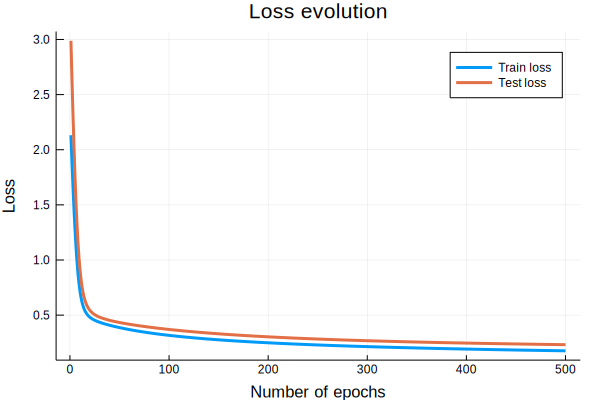

In [94]:
Plots.plot(hcat(tr_loss_evol,te_loss_evol), title="Loss evolution",label=["Train loss" "Test loss"],lw=3)
xlabel!("Number of epochs")
ylabel!("Loss")

Nous remarquons que les deux fonctions de coût décroient rapidement dans les premières itérations, puis commence à se stabiliser en augmentant le nombre d'itérations.

Regardons maintenant l'evolution de la précision (pourcentage de bonne réponses) sur les deux ensembles.

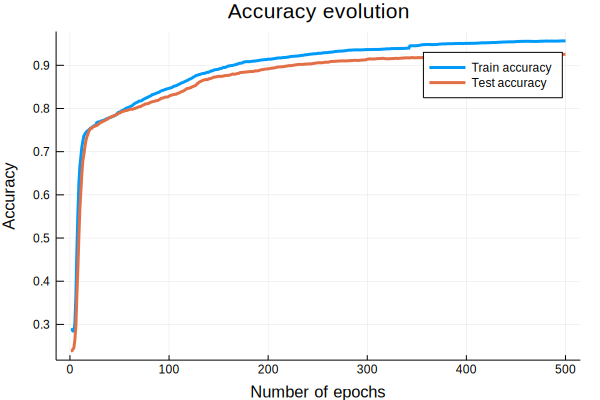

In [95]:
Plots.plot(hcat(tr_accuracy_evol,te_accuracy_evol), title="Accuracy evolution",label=["Train accuracy" "Test accuracy"],lw=3)
xlabel!("Number of epochs")
ylabel!("Accuracy")

In [96]:
accuracy(X_test,y_test,theta)

0.9256284916201117

### Résultats:

Nous remarquons qu'on atteint une précision de **92%**.

Cela est largement meilleure que la régression logistique en utilisant l'algorithme de Metropolis-Hastings (100 itérations). Cependant, on est proche de la performance de la classification Naïve Bayésienne. Ces deux performances ne sont pas très comparables puisque nous n'avons pas utilisé le même nombre de mots dans chacune des deux méthodes.

In [97]:
predict(X_train[1496,:], theta)

C'est un Ham !

In [98]:
y_train[1496]

0.0

Nous avons donc une bonne prédiction

Essayons maintenant de prédire à partir du chemin d'un fichier, si ce fichier est un spam ou un ham

In [99]:
predict_from_file("./data/enron2/ham/0041.1999-12-17.kaminski.ham.txt", theta)

./data/enron2/ham/0041.1999-12-17.kaminski.ham.txt --> C'est un Ham !


### Conclusion de la régression logistique:

Pour estimer les poids, nous avons eu recours à deux algorithmes: 

- Metropolis Hastings: Cet algorithme permet de converger quelque soit l'initialisation de nos paramètres, d'où son utilisation. Le problème est qu'il est moins utilisé quand le nombre de paramètres devient grand; On utiise l'algorithme de Gibbs dans ce cas. Mais en n'ayant pas la loi de la loi conditionnelle complète des paramètres, nous ne pouvons qu'utiliser Metropolis Hasting avec un nombre de paramètres égal à 907. Nous remarquons aussi qu'avec 100 itérations **(très peu)**, nous avons attendu environs 5 minutes, ce qui limite la recherche de meilleurs paramètres.

- Descente de gradient: Cet algorithme est un algorithme de classification très robuste, qui malgré les performances des nouveaux algorithmes tels que les réseaux de neurones, est toujours utilisés dans beaucoup de domaines. Nous avons aussi pu voir la rapidité de l'entrainement (500 itérations) qui nous a permis d'arriver à 0.87% en précision sur l'ensemble de Test.

### IV. <a id = "unit4" > </a >  Références 
____




(1) Base de données utilisée 
: https://labs-repos.iit.demokritos.gr/skel/i-config/downloads/enron-spam/preprocessed/ ; 

(2) Sur la base de données d'enron: https://en.wikipedia.org/wiki/Enron_Corpus  

(3) Classification naïve bayésienne:  https://fr.wikipedia.org/wiki/Classification_na%C3%AFve_bay%C3%A9sienne

(4) Laplace smoothing: 
-  https://en.wikipedia.org/wiki/Additive_smoothing  
- https://stats.stackexchange.com/questions/108797/in-naive-bayes-why-bother-with-laplace-smoothing-when-we-have-unknown-words-in    

(5) Surapprentissage: https://fr.wikipedia.org/wiki/Surapprentissage  

(6) Metropolis-Hastings : http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf  

(7) Descente de gradient: https://eric.univ-lyon2.fr/~ricco/cours/slides/gradient_descent.pdf

(8) Régression logistique: https://data.princeton.edu/wws509/notes/c3.pdf